<a href="https://colab.research.google.com/github/pietromiotti/diffLogic/blob/main/diffLogic_tutorial_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Building a Differentiable Logic Gate Network in JAX


Author: Pietro Miotti


This hands on notebook will walk through a **minimal yet complete** implementation of a [Differentiable Logic (diffLogic) Gate Network](https://arxiv.org/abs/2210.08277) from Petersen et al, and use it to construct and train a 4 bit binary adder.

Key points

1. JAX implementation of diffLogic primitives.
2. Build a tiny logic‑net that learns the **full truth table** of a 4 bit adder.
3. Analyse the learned discrete gate distribution.

Feel free to **run the cells as you read**, every code block is self contained (and executes better on GPU).

Why am I doing this? After we published the [diffLogic CA](https://google-research.github.io/self-organising-systems/difflogic-ca/) blog post a couple of months ago, I've realized there is a certain interest in the field and wanted to put some effort into creating a simple colab which contains both the theoretical concepts and the main functions, hopefully lowering the barrier and making it more digestible for everyone :) Have fun!

Here you can find the preprint [article](https://arxiv.org/abs/2506.04912). If instead you are interested to learn about DiffLogic CA in a podcast format, here it is the NotebookLM generated content that summarize (and hype a bit) the content of the blog post, [podcast](https://notebooklm.google.com/notebook/3278360f-c7ab-46c6-a4e2-429a2e3e1906/audio).



If you find this tutorial helpful, please cite the following work for attribution in academic contexts, since we used the main code from there:

```
@misc{https://doi.org/10.48550/arxiv.2506.04912,
  doi = {10.48550/ARXIV.2506.04912},
  url = {https://arxiv.org/abs/2506.04912},
  author = {Miotti,  Pietro and Niklasson,  Eyvind and Randazzo,  Ettore and Mordvintsev,  Alexander},
  keywords = {Artificial Intelligence (cs.AI),  FOS: Computer and information sciences,  FOS: Computer and information sciences},
  title = {Differentiable Logic Cellular Automata: From Game of Life to Pattern Generation},
  publisher = {arXiv},
  year = {2025},
  copyright = {Creative Commons Attribution 4.0 International}
}
```

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## 1. Imports & Utilities

We start by importing the Python and JAX libraries (https://github.com/google/jax), along with a few helper functions that we’ll use throughout the notebook. Nothing fancy. Note: the plotting functions are completely generated, so blame Claude for those.

In [ ]:
# @title Imports and Utils
from collections import namedtuple
import io
from typing import List, Optional, Sequence, Tuple

import flax.linen as nn
from IPython.display import HTML, Image, clear_output
import jax
from jax import grad
import jax.numpy as jnp
import jax.random as random
from jax.tree_util import tree_leaves, tree_map

from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import numpy as np
import optax


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'text.usetex': False,  # Set to True if LaTeX is available
    'axes.linewidth': 1.2,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 5,
    'xtick.minor.size': 3,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.shadow': False,
    'legend.framealpha': 0.9,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

COLORS = {
    'primary': '#1f77b4',
    'secondary': '#d62728',
    'accent': '#ff7f0e',
    'neutral': '#7f7f7f',
    'success': '#2ca02c',
    'background': '#fafafa',
    'grid': '#e0e0e0'
}

def plot_hist_gates(
    net,
    save_path=None,
    title='Gate Distribution Analysis',
    figsize=(14, 8),
    show_percentages=True,
    highlight_top_n=3
):

    gate_types = [
        'FALSE', 'AND', 'A ∧ ¬B', 'A', '¬A ∧ B', 'B', 'XOR', 'OR',
        'NOR', 'XNOR', '¬B', 'A ∨ ¬B', '¬A', '¬A ∨ B', 'NAND', 'TRUE'
    ]

    gate_counts = np.bincount(net, minlength=len(gate_types))
    total_gates = np.sum(gate_counts)
    gate_percentages = (gate_counts / total_gates) * 100

    # Sort by count
    sorted_indices = np.argsort(gate_counts)
    sorted_counts = gate_counts[sorted_indices]
    sorted_percentages = gate_percentages[sorted_indices]
    sorted_gate_types = [gate_types[i] for i in sorted_indices]

    # Create figure with custom layout
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

    # Main histogram
    ax1 = fig.add_subplot(gs[0])

    # Color scheme: highlight top gates
    colors_list = [COLORS['neutral']] * len(sorted_counts)
    for i in range(min(highlight_top_n, len(sorted_counts))):
        colors_list[-(i+1)] = COLORS['primary']

    bars = ax1.barh(
        range(len(sorted_gate_types)),
        sorted_counts,
        color=colors_list,
        alpha=0.8,
        edgecolor='white',
        linewidth=0.8,
        height=0.7
    )

    # Add percentage labels if requested
    if show_percentages:
        for i, (count, pct) in enumerate(zip(sorted_counts, sorted_percentages)):
            if count > 0:
                ax1.text(
                    count + max(sorted_counts) * 0.01,
                    i,
                    f'{count:,} ({pct:.1f}%)',
                    va='center',
                    ha='left',
                    fontsize=9,
                    fontweight='medium'
                )


    ax1.set_yticks(range(len(sorted_gate_types)))
    ax1.set_yticklabels(sorted_gate_types, fontsize=10)
    ax1.set_xlabel('Number of Gates', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Gate Type', fontsize=12, fontweight='bold')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)

    ax1.grid(True, axis='x', alpha=0.3, linestyle='-', color=COLORS['grid'])
    ax1.set_axisbelow(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.2)
    ax1.spines['bottom'].set_linewidth(1.2)

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')

    non_zero_gates = np.sum(gate_counts > 0)
    max_count = np.max(gate_counts)
    max_gate = gate_types[np.argmax(gate_counts)]

    stats_text = f"""
    SUMMARY STATISTICS

    Total Gates: {total_gates:,}
    Unique Types: {non_zero_gates}/{len(gate_types)}

    Most Common:
    {max_gate}
    ({max_count:,} gates, {(max_count/total_gates)*100:.1f}%)

    Gate Diversity:
    {(non_zero_gates/len(gate_types))*100:.1f}% of possible types

    Distribution:
    Mean: {np.mean(gate_counts):.1f}
    Std: {np.std(gate_counts):.1f}
    """

    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
             fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.5", facecolor=COLORS['background'], alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg', facecolor='white',
                   bbox_inches='tight', pad_inches=0.2)

    plt.show()


def plot_training_progress(
    loss_train,
    loss_test,
    compute_every,
    save_path=None,
    title='Training Dynamics: Soft vs Hard Gate Optimization',
    figsize=(12, 6),
    show_smoothed=True,
    smoothing_window=50
):

    fig, ax = plt.subplots(figsize=figsize, facecolor='white')

    # Prepare data
    train_steps = np.arange(len(loss_train))
    test_steps = np.arange(0, len(loss_train), compute_every)[:len(loss_test)]

    # Plot raw data with subtle styling
    ax.plot(
        train_steps, loss_train,
        color=COLORS['primary'],
        linewidth=1.2,
        alpha=0.6,
        label='Soft Gates'
    )

    ax.plot(
        test_steps, loss_test,
        color=COLORS['secondary'],
        linewidth=1.5,
        alpha=0.8,
        marker='o',
        markersize=2.5,
        markevery=max(1, len(loss_test)//30),
        label='Hard Gates'
    )

    # Add smoothed lines if requested
    if show_smoothed and len(loss_train) > smoothing_window:
        # Simple moving average
        def smooth(data, window):
            return np.convolve(data, np.ones(window)/window, mode='valid')

        smoothed_train = smooth(loss_train, smoothing_window)
        smoothed_steps = train_steps[smoothing_window-1:]

        ax.plot(
            smoothed_steps, smoothed_train,
            color=COLORS['primary'],
            linewidth=2.5,
            alpha=1.0,
            label='Soft Gates (Trend)',
            linestyle='-'
        )

        if len(loss_test) > smoothing_window//compute_every:
            smoothed_test = smooth(loss_test, max(3, smoothing_window//compute_every))
            smoothed_test_steps = test_steps[max(3, smoothing_window//compute_every)-1:][:len(smoothed_test)]

            ax.plot(
                smoothed_test_steps, smoothed_test,
                color=COLORS['secondary'],
                linewidth=2.5,
                alpha=1.0,
                label='Hard Gates (Trend)',
                linestyle='--'
            )

    # Professional formatting
    ax.set_xlabel('Training Steps', fontsize=13, fontweight='bold')
    ax.set_ylabel('Loss Value', fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)

    # Grid and spines
    ax.grid(True, alpha=0.25, linestyle='-', color=COLORS['grid'], linewidth=0.8)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Enhanced legend
    legend = ax.legend(
        loc='upper right',
        frameon=True,
        framealpha=0.95,
        fancybox=False,
        shadow=False,
        fontsize=11,
        edgecolor='gray',
        facecolor='white'
    )
    legend.get_frame().set_linewidth(0.8)

    # Format axes with better spacing
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add subtle background
    ax.set_facecolor('#fafafa')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg', facecolor='white',
                   bbox_inches='tight', pad_inches=0.2)

    plt.show()


def plot_gate_evolution_heatmap(
    gate_history,
    save_path=None,
    title='Gate Type Evolution During Training',
    figsize=(14, 6)
):

    gate_types = [
        'FALSE', 'AND', 'A∧¬B', 'A', '¬A∧B', 'B', 'XOR', 'OR',
        'NOR', 'XNOR', '¬B', 'A∨¬B', '¬A', '¬A∨B', 'NAND', 'TRUE'
    ]

    # Build evolution matrix
    evolution_matrix = []
    for gates in gate_history:
        counts = np.bincount(gates, minlength=len(gate_types))
        proportions = counts / np.sum(counts) if np.sum(counts) > 0 else counts
        evolution_matrix.append(proportions)

    evolution_matrix = np.array(evolution_matrix).T

    fig, ax = plt.subplots(figsize=figsize, facecolor='white')

    # Create heatmap
    im = ax.imshow(
        evolution_matrix,
        aspect='auto',
        cmap='viridis',
        interpolation='nearest'
    )

    # Formatting
    ax.set_yticks(range(len(gate_types)))
    ax.set_yticklabels(gate_types, fontsize=10)
    ax.set_xlabel('Training Checkpoint', fontsize=12, fontweight='bold')
    ax.set_ylabel('Gate Type', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Proportion of Gates', fontsize=11, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg', facecolor='white',
                   bbox_inches='tight', pad_inches=0.2)

    plt.show()


In [ ]:
# @title Macro

# Index of the pass-through gate used for network initialization. This is extremely important.
PASS_THROUGH_GATE = 3 #This is the index that refers to the pass-though-gate A (the index of B is fine as well)
DEFAULT_PASS_VALUE = 10.0

# Number of possible gates with 2 inputs and 1 output.
NUMBER_OF_GATES = 16


## 2. Core diffLogic Primitives

### Quick Summary

Differentiable Logic Gate Netowkrs (DLGNs) are structured as **layers** of interconnected gates,
similar to how standard neural networks consist of layers of
neurons. While standard neural networks allow each neuron
to connect to many or all neurons in the adjacent layers,
DLGNs maintain a stricter connectivity patterns where
**each gate receives input from exactly two gates, randomly
sampled from the previous layer**. This creates a sparse
network architecture in comparison to traditional dense
neural networks. Apart from the topological difference, the
fundamental distinction lies in what gets learned during
training. In standard neural networks, the strength of
connections between neurons (weights) is adjusted during
learning, while the computation each neuron performs (the
sum and nonlinearity) remains fixed. In contrast, **DLGNs
keep their wiring structure fixed during training**, and learn
which logical operation each gate should perform. **To
enable gradient-based learning, DLGNs replace discrete
boolean operations with their continuous relaxation,** that operate on continuous values between 0 and 1, enabling gradients to flow and therefore learning
using back-propagation. During training, each DLGN gate
maintains a probability distribution across all 16 possible
binary logic operations (2 inputs, 1 output), gradually
learning the most effective operation to perform at the
particular gate, in tandem with all other gates. **At inference
time, the network crystallizes into a deterministic circuit
with each gate performing its most probable operation.**
These circuits can then be mapped to FPGAs, or even taped
out as ASICs, with inference measured in nanoseconds, as
shown in [Petersen et al. (2022)](https://arxiv.org/abs/2210.08277).


Below you will find the **core implementation**: we took inspiration from the repo [diffLogic open‑source repo](https://github.com/Felix-Petersen/difflogic), but we mainly used the code from [diffLogic Cellular Automata](https://google-research.github.io/self-organising-systems/difflogic-ca/).

### Key Concepts

The differentiable logic gate approach enables gradient-based training of logic networks through four main ideas:

#### **Soft Gate Representation**
Each neuron in the network is parameterized by a categorical probability distribution over all 16 possible binary logic gates. For a neuron with parameters $\mathbf{w} \in \mathbb{R}^{16}$, the probability of selecting gate $i$ is:

$$p_i = \frac{e^{w_i}}{\sum_{j=0}^{15} e^{w_j}}$$

where $\mathbf{p} \in \mathbb{R}^{16}$, with $p_i \in [0,1]$ and $\sum_{i=0}^{15} p_i = 1$.

Why 16? The total possible truth tables with 2 input and 1 output are 16 :)


#### **Differentiable Forward Pass**
During training, instead of selecting a single gate, we compute the **weighted average** of all 16 relaxed (real valued) gate outputs. For inputs $a, b \in [0,1]$, the neuron activation is:

$$a' = \sum_{i=0}^{15} p_i \cdot f_i(a, b)$$

where $f_i$ is the $i$-th real valued logic operator. For example:
- **AND**: $f_{\text{AND}}(a, b) = a \cdot b$
- **OR**: $f_{\text{OR}}(a, b) = a + b - a \cdot b$
- **XOR**: $f_{\text{XOR}}(a, b) = a + b - 2a \cdot b$

These correspond to the continuous relaxation of logic gates. Below the complete list of gates and their continuous relaxation used in this work.



| idx | Gate                 | Continuous Relaxation      | AB=00 | AB=01 | AB=10 | AB=11 |
|-----|----------------------|----------------------------|-------|-------|-------|-------|
|  0  | 0                    | 0                          | 0     | 0     | 0     | 0     |
|  1  | A and B              | a * b                      | 0     | 0     | 0     | 1     |
|  2  | not(A -> B)          | a - a * b                  | 0     | 0     | 1     | 0     |
|  3  | A                    | a                          | 0     | 0     | 1     | 1     |
|  4  | not(B -> A)          | b - a * b                  | 0     | 1     | 0     | 0     |
|  5  | B                    | b                          | 0     | 1     | 0     | 1     |
|  6  | A xor B              | a + b - 2 * a * b          | 0     | 1     | 1     | 0     |
|  7  | A or B               | a + b - a * b              | 0     | 1     | 1     | 1     |
|  8  | not(A or B)          | 1 - (a + b - a * b)        | 1     | 0     | 0     | 0     |
|  9  | not(A xor B)         | 1 - (a + b - 2 * a * b)    | 1     | 0     | 0     | 1     |
|  10 | not(B)               | 1 - b                      | 1     | 0     | 1     | 0     |
|  11 | B -> A               | 1 - b + a * b              | 1     | 0     | 1     | 1     |
|  12 | not(A)               | 1 - a                      | 1     | 1     | 0     | 0     |
|  13 | A -> B               | 1 - a + a * b              | 1     | 1     | 0     | 1     |
|  14 | not(A and B)         | 1 - a * b                  | 1     | 1     | 1     | 0     |
|  15 | 1                    | 1                          | 1     | 1     | 1     | 1     |

#### **Discrete Inference**
After training, we **discretize** the network by selecting the most probable gate for each neuron:

$$\text{gate}_{\text{selected}} = \arg\max_i \, p_i$$

This produces a pure Boolean logic network that operates on $\{0,1\}$ values and can execute pretty fast.


#### **Wiring**

The wiring can be either fully random, or we can favor unique connections by manually creating the pairs and then applying a permutation... and maybe can be learned!!!

---

###  Overview

The code below implements these concepts. Key functions include:

- `bin_op_all_combinations()`: Computes all 16 possible binary operations in parallel
- `decode_soft()` / `decode_hard()`: Switches between probabilistic (training) and discrete (inference) modes  
- `init_gates()`: Initializes gate parameters **with a bias toward pass-through operations**
- `run_layer()` / `run_circuit()`: Executes forward passes through layers and full networks


In [ ]:
# From https://github.com/Felix-Petersen/difflogic/tree/main/difflogic
def get_unique_connections(in_dim, out_dim, key):
  assert (
      out_dim * 2 >= in_dim
  )  # Number of neurons must not be smaller than half of inputs
  x = jnp.arange(in_dim)
  # Take pairs (0, 1), (2, 3), (4, 5), ...
  a = x[::2]
  b = x[1::2]
  m = min(a.shape[0], b.shape[0])
  a = a[:m]
  b = b[:m]
  # If needed, add pairs (1, 2), (3, 4), (5, 6), ...
  if a.shape[0] < out_dim:
    a_ = x[1::2]
    b_ = x[2::2]
    m = min(a_.shape[0], b_.shape[0])
    a = jnp.concatenate([a, a_[:m]])
    b = jnp.concatenate([b, b_[:m]])
  # If still needed, add pairs with larger offsets
  offset = 2
  while out_dim > a.shape[0] and offset < in_dim:
    a_ = x[:-offset]
    b_ = x[offset:]
    a = jnp.concatenate([a, a_])
    b = jnp.concatenate([b, b_])
    offset += 1

  if a.shape[0] >= out_dim:
    a = a[:out_dim]
    b = b[:out_dim]
  else:
    raise ValueError(
        f'Could not generate enough unique connections: {a.shape[0]} <'
        f' {out_dim}'
    )

  # Random permutation
  perm = jax.random.permutation(key, out_dim)
  a = a[perm]
  b = b[perm]

  return a, b


def bin_op_all_combinations(a, b):
  # Implementation of binary operations between two inputs for all the 16 different operations (continuous relaxation)
  return jnp.stack(
      [
          jnp.zeros_like(a),
          a * b,
          a - a * b,
          a,
          b - a * b,
          b,
          a + b - 2 * a * b,
          a + b - a * b,
          1 - (a + b - a * b),
          1 - (a + b - 2 * a * b),
          1 - b,
          1 - b + a * b,
          1 - a,
          1 - a + a * b,
          1 - a * b,
          jnp.ones_like(a),
      ],
      axis=-1,
  )


def bin_op_s(a, b, i_s):
  # Compute all possible operations
  combinations = bin_op_all_combinations(
      a, b
  )  # Shape: (n_gate, n_possible_gates, NUMBER_OF_GATES)
  """
    Calculate the weighted sum of all possible gate operations.
    During training (soft decoding), the weights are the probabilities
    of each gate type. During inference (hard decoding), the weights
    are a one-hot vector representing the selected gate type.
  """
  result = jax.numpy.sum(combinations * i_s[None, ...], axis=-1)
  return result


def decode_soft(weights):
  """
  From the weights vector compute the probability distribution of choosing each gate using softmax.
  In this way the 16th dimensional vector is transformed in a probability distribution.
  """
  return nn.softmax(weights, axis=-1)

def decode_hard(weights):
  return jax.nn.one_hot(
      jnp.argmax(weights, axis=-1), NUMBER_OF_GATES
  )  # Only return the gate with maximum probability.


# Initialize gates as pass through gate
def init_gates(
    n,
    num_gates=NUMBER_OF_GATES,
    pass_through_gate=PASS_THROUGH_GATE,
    default_pass_value=DEFAULT_PASS_VALUE,
):
  """Initializes a gate matrix with default pass-through values.

  Args:
      n: The number of rows in the gate matrix.
      num_gates: The number of gates (columns). Defaults to NUMBER_OF_GATES.
      pass_through_gate: The index of the pass-through gate column. Defaults to
        PASS_THROUGH_GATE (either A or B).
      default_pass_value: The default value for the pass-through gate. Defaults
        to DEFAULT_PASS_VALUE.

  Returns:
      An array representing the initialized gate matrix.
  """
  gates = jnp.zeros((n, num_gates)) #different initialization of the other gates can be explored.

  # ---> THIS LINE IS SUPER IMPORTANT!
  gates = gates.at[:, pass_through_gate].set(default_pass_value)
  return gates


def init_gate_layer(key, in_dim, out_dim, connections):

  # With 'random' connections the input of each gate are sampled randomly from the previous layer.
  if connections == 'random':
    key1, key2 = jax.random.split(key)

    c = jax.random.permutation(key2, 2 * out_dim) % in_dim
    c = jax.random.permutation(key1, in_dim)[c]

    c = c.reshape(2, out_dim)

    indices_a = c[0, :]
    indices_b = c[1, :]

  # With 'unique' connections each gate will have a different pair of inputs.
  elif connections == 'unique':
    indices_a, indices_b = get_unique_connections(in_dim, out_dim, key)

  # Feel free to create your connection :)

  else:
    raise ValueError(f'Connection type {connections} not implemented')

  wires = [indices_a, indices_b]
  gate_logits = init_gates(out_dim)
  return gate_logits, wires


def init_logic_gate_network(hyperparams, params, wires, key):
  for i, (in_dim, out_dim) in enumerate(
      zip(hyperparams['layers'][:-1], hyperparams['layers'][1:])
  ):
    key, subkey = jax.random.split(key)
    gate_logits, gate_wires = init_gate_layer(
        subkey, int(in_dim), int(out_dim), hyperparams['connections'][i]
    )
    params.append(gate_logits)
    wires.append(gate_wires)



# In the current implementation all the kernels share the same connection scheme
def init_diff_logic(hyperparams, key):

  key, subkey = jax.random.split(key)
  """Initialize parameters for the update and perceive networks.

   Each network's parameters will be stored as a list of gate logits.

   List of gate logits for the update network.
   Each element is a JAX array with shape (out_dim, 16),
   where out_dim is the output dimension of the layer.

  """
  params = []

  """Initialize wiring for the update and perceive networks.

   Each network's wiring will be stored as a list of connection indices.

   List of connection indices for the update network.
   Each element is a tuple of two JAX arrays (indices_a, indices_b)
   representing the input indices for each gate.

  """
  wires = []

  # Initialize the gate
  init_logic_gate_network(
      hyperparams, params, wires, subkey
  )

  return params, wires


def run_layer(logits, wires, x, training):
  """Args:

      x: input vector, shape (input_dim, 1).
      wires: wire configuration, shape (out_dim, 1).
      logits: gate parameters, shape (n_out, 16).

  Returns:
      If training is True, the expected gate values.
      If training is False, the gates with maximum probability.
  """
  a = x[..., wires[0]]
  b = x[..., wires[1]]
  logits = jax.lax.cond(training, decode_soft, decode_hard, logits)
  out = bin_op_s(a, b, logits)[-1]

  return out

def run_circuit(params, wires, x, training):
  for g, c in zip(params, wires):
    x = run_layer(g, c, x, training)
  return x


# patches = [batch_size, output]
def v_run_circuit_map(x, params, wires, training):
  v_run_circuit = jax.vmap(
      run_circuit, in_axes=(None, None, 0, None)
  )  # vmap over the batches
  x = v_run_circuit(params, wires, x, training)
  return x

## 3. Dataset: Full Truth Table of a 4bit Adder

In this example we enumerate **all** $2^{8}=256$ combinations of two 4 bit integers and compute their **5 bit** sum (carry included).  The function below `generate_4bit_adder_dataset()` returns a dict containing:

* `inputs` → `[N, 8]` Boolean matrix of the two operands.
* `targets` → `[N, 5]` Boolean matrix of the desired sum.

In [ ]:
def generate_4bit_adder_dataset():
    """Generate complete dataset for 4-bit binary addition. 8 input, 5 output """
    inputs, targets = [], []

    for a in range(16):
        for b in range(16):
            # Convert to binary
            a_bits = np.unpackbits(np.array([a], dtype=np.uint8), bitorder='big')[-4:].tolist() # 4 bits
            b_bits = np.unpackbits(np.array([b], dtype=np.uint8), bitorder='big')[-4:].tolist() # 4 bits
            input_bits = a_bits + b_bits

            # Result: [carry, s3,s2,s1,s0]
            result = a + b
            result_bits = np.unpackbits(np.array([result], dtype=np.uint8), bitorder='big')[-5:].tolist()
            target_bits = result_bits

            inputs.append(input_bits)
            targets.append(target_bits)

    return {
        'inputs': jnp.array(inputs, dtype=jnp.float32),
        'targets': jnp.array(targets, dtype=jnp.float32)
    }


dataset = generate_4bit_adder_dataset()

## 4. Hyper‑parameters and Training Setup

Here we specify model and optimiser parameters.

We use [`optax`](https://github.com/deepmind/optax) for Adam + gradient clipping + **weight decay** (is super important!!)

In [ ]:
OUTPUT_SIZE = dataset['targets'].shape[-1]

hyperparams = {}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.05
hyperparams['num_epochs'] = 5000
hyperparams['layers'] = (
    [128] * 20 + [64, 32, OUTPUT_SIZE]
)
hyperparams['connections'] = ['random'] * len(
    hyperparams['layers']
)

key = random.PRNGKey(hyperparams['seed'])

## 5. Training Loop

The cell below implements a classical training loop using JAX’s style:

* `train_step` computes soft and hard losses in parallel.
* We store both to visualise convergence and track when the gates discreetise.


In [ ]:
TrainState = namedtuple('TrainState', 'param opt_state key')

# Create optimizer
opt = optax.chain(
    optax.clip(100.0),  # Clips by value
    optax.adamw(
        learning_rate=hyperparams['lr'], b1=0.9, b2=0.99, weight_decay=1e-2
    ),
)

def init_state(hyperparams, opt, key_from_seed):
  key, subkey = random.split(key_from_seed, 2)
  #init parameters (wires are fixed, not passed in the state)
  params, wires = init_diff_logic(hyperparams, subkey)
  #opt state
  opt_state = opt.init(params)
  return TrainState(params, opt_state, key), wires


def loss_f(params, wires, train_x, train_y):
  def eval(params, training):
    y = v_run_circuit_map(
        train_x, params, wires, training)
    return jax.numpy.square(y - train_y).sum()

  return eval(params, 1), eval(params, 0)

val_and_grad = jax.value_and_grad(loss_f, argnums=0, has_aux=True)

# Helper function that can be used for clipping parameters.
upd_f = lambda p: p

@jax.jit
def train_step(
    train_state, train_x, train_y, wires):
  params, opt_state, key = train_state
  key, k1 = jax.random.split(key, 2)
  (loss, hard), dx = val_and_grad(
      params, wires, train_x, train_y)
  dx, opt_state = opt.update(dx, opt_state, params)
  new_params = optax.apply_updates(params, dx)
  new_params = upd_f(new_params)
  return TrainState(new_params, opt_state, key), loss, hard

## 6. Results & Visualisation

After training completes we expect **zero error** on the full truth table, the network should exactly replicate the binary adder.  We then:

1. Compute accuracy of the *hard* network.
2. Inspect a histogram of chosen gates.

Beaware, it might happen that the circuit does not converge **every time** that is mainly because of how sensitive it is to numerical stability. There is quite a lot to dig here.

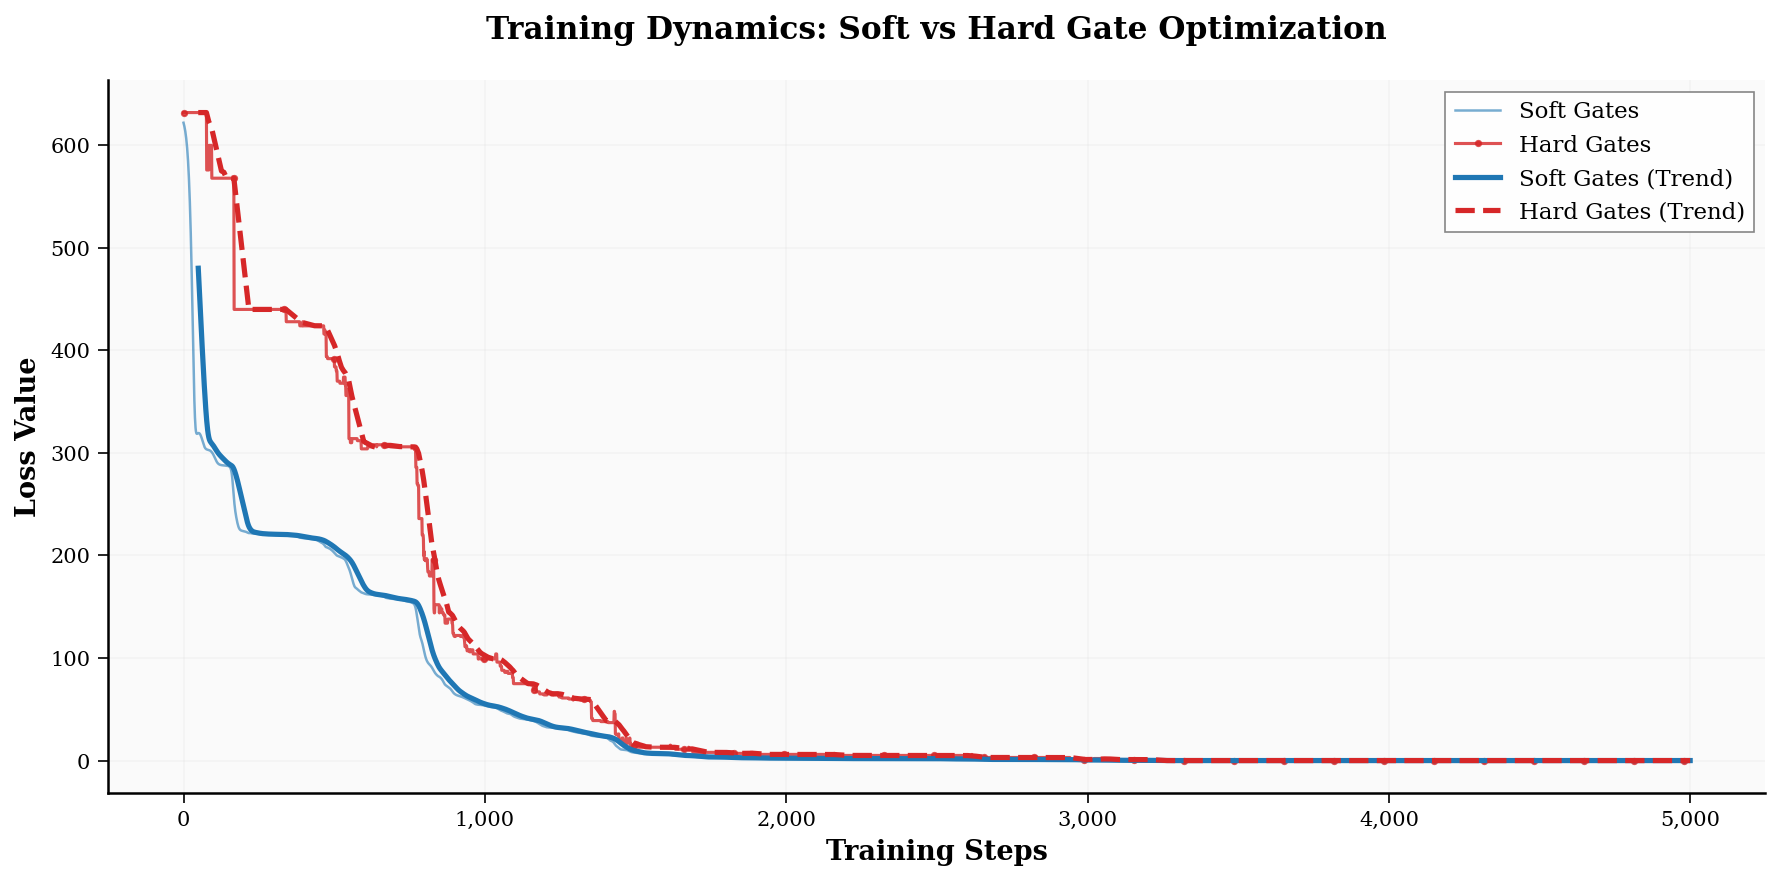

In [ ]:
train_state, wires = init_state(hyperparams, opt, key)

loss_soft = []
loss_hard = []

for i in range(hyperparams['num_epochs']):
  train_state, soft_loss, hard_loss = train_step(
      train_state,
      dataset['inputs'],
      dataset['targets'],
      wires)
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss)

  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss)

clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'loss.svg')

## 7. Analysing Learned Gate Distributions

Finally we plot the frequency of each of the 16 possible gates in every layer.  
Feel free to experiment by changing network depth/width and re-running the notebook.

TOTAL GATES:   720


<ipython-input-1-9042d137881c>:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


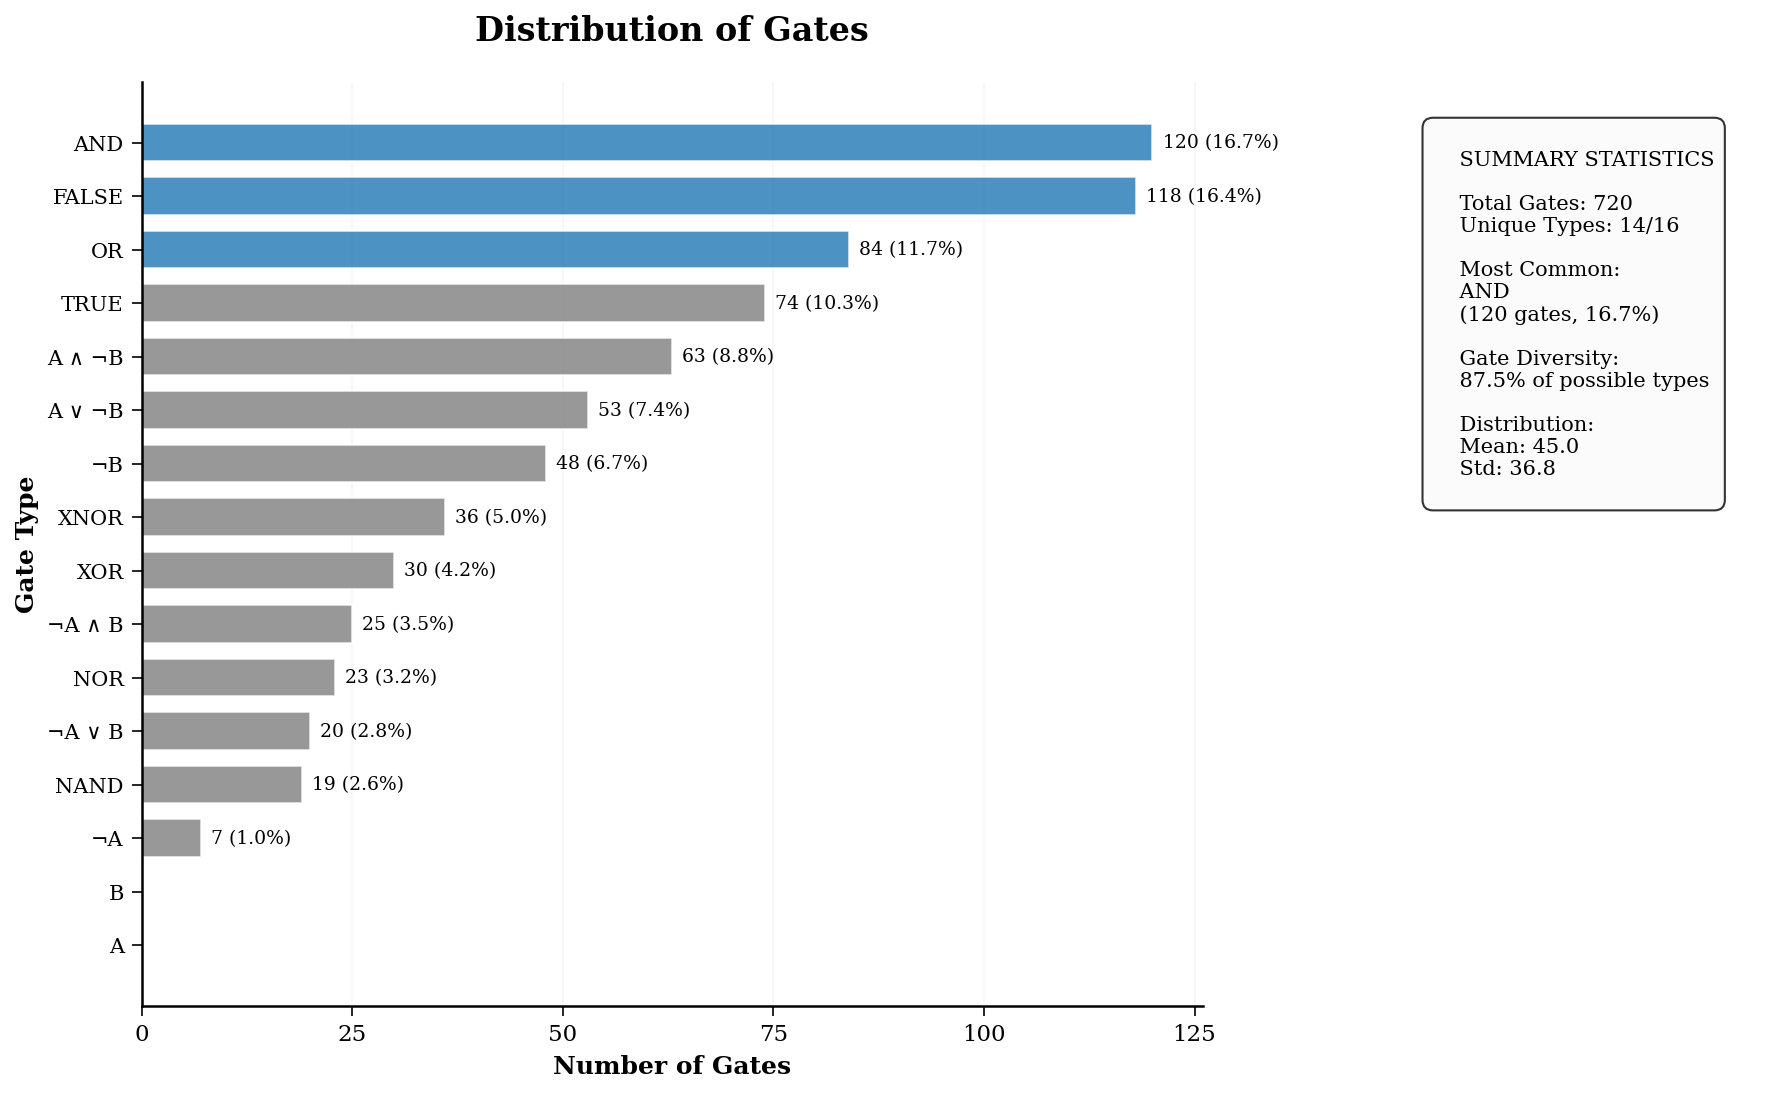

In [ ]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)

#Excluding the pass gate for A and B
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)

total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)

# Update Network
networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(analyze_circuit)
]
net = jax.numpy.concatenate(networks_stats, axis=0)
net = net[((net != 3) & (net != 5))]

plot_hist_gates(
    net, 'gates.svg', 'Distribution of Gates'
)

## 8. Sanity Check

Play a bit with your calculator to see your results!

In [ ]:
params, opt_state, key = train_state

# Pick your favourite numbers
a = 3
b = 8

# Convert a and b to binray (4 bit)
a_bits = np.unpackbits(np.array([a], dtype=np.uint8), bitorder='big')[-4:].tolist() # 4 bits
b_bits = np.unpackbits(np.array([b], dtype=np.uint8), bitorder='big')[-4:].tolist() # 4 bits

# Combine the bits to form the input vector
input_bits = a_bits + b_bits

# expected target
out_target = a + b
target_bits = np.unpackbits(np.array([out_target], dtype=np.uint8), bitorder='big')[-5:].tolist() # 5 bits for sum

print("Input bits:", input_bits)
print("Target bits:", target_bits)

input_for_network = np.array(input_bits, dtype=np.float32).reshape(1, -1)

#output (exclude batch dimension)
out_raw = v_run_circuit_map(input_for_network, params, wires, 0)[0]
out = out_raw.astype(dtype=np.uint8).tolist()

print("Network output bits:", out)

# pad
zero_pad_4bit = [0, 0, 0, 0]

# Convert the 4 bit inputs back to decimal
a_again = np.packbits(np.array(zero_pad_4bit + input_bits[0:4], dtype=np.uint8))[0].tolist()
b_again = np.packbits(np.array(zero_pad_4bit + input_bits[4:8], dtype=np.uint8))[0].tolist()

# Convert the 5 bit output back to decimal (but skip the first bit, the carry)
out_dec = np.packbits(np.array(zero_pad_4bit + out[1:], dtype=np.uint8))[0].tolist()

print("Input A (decimal):", a_again)
print("Input B (decimal):", b_again)
print("Network Output (decimal):", out_dec)
print("Expected Target (decimal):", out_target)

if out_dec == out_target:
    print("Hurray! Network output matches target.")
else:
    print("Bad bad bad...Network output does NOT match target.")

Input bits: [0, 0, 1, 1, 1, 0, 0, 0]
Target bits: [0, 1, 0, 1, 1]
Network output bits: [0, 1, 0, 1, 1]
Input A (decimal): 3
Input B (decimal): 8
Network Output (decimal): 11
Expected Target (decimal): 11
Hurray! Network output matches target.
